### Regresión logística

https://www.youtube.com/@ellocodelosdatos

Regresión Logística es un algoritmo de clasificación que predice la probabilidad de que una observación pertenezca a una de dos categorías (ej: Sí/No, 0/1). Usa la función sigmoide para convertir valores numéricos en probabilidades entre 0 y 1, aplicando un umbral (generalmente 0.5) para decidir la clase final.

Ejemplo: Predecir si un correo es spam (1) o no spam (0) basado en palabras clave.

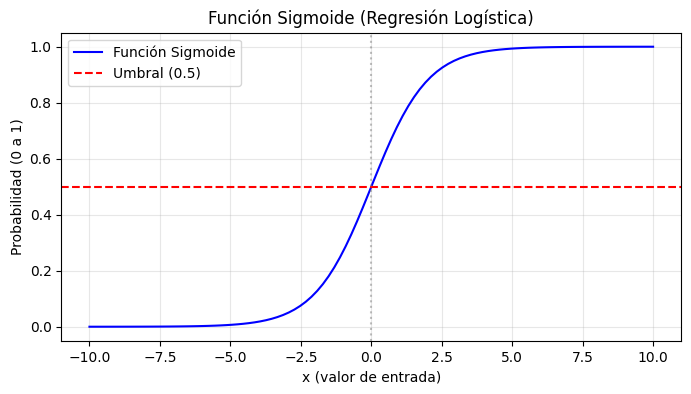

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Función sigmoide: 1 / (1 + e^(-x))
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

# Generar valores de x (rango amplio para ver la curva completa)
x = np.linspace(-10, 10, 100)  # 100 puntos entre -10 y 10
y = sigmoide(x)  # Calcular y = sigmoide(x)

# Graficar
plt.figure(figsize=(8, 4))
plt.plot(x, y, label='Función Sigmoide', color='blue')
plt.axhline(0.5, color='red', linestyle='--', label='Umbral (0.5)')
plt.axvline(0, color='gray', linestyle=':', alpha=0.5)
plt.title('Función Sigmoide (Regresión Logística)')
plt.xlabel('x (valor de entrada)')
plt.ylabel('Probabilidad (0 a 1)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#### Importamos librerías

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle

#### Cargamos datos

| Columna                  | Explicación                                      |
|--------------------------|--------------------------------------------------|
| Call Failure             | Número de fallos en llamadas                     |
| Complaints               | Binario (0: Sin queja, 1: Con queja)             |
| Subscription Length      | Meses totales de suscripción                     |
| Charge Amount            | Atributo ordinal (0: Monto más bajo, 9: Monto más alto) |
| Seconds of Use           | Segundos totales de llamadas                     |
| Frequency of use         | Número total de llamadas                         |
| Frequency of SMS         | Número total de mensajes de texto                 |
| Distinct Called Numbers  | Número total de teléfonos distintos llamados      |
| Age Group                | Atributo ordinal (1: Grupo de edad más joven, 5: Grupo de edad más mayor) |
| Tariff Plan              | Binario (1: Pago por uso, 2: Contrato)           |
| Status                   | Binario (1: Activo, 2: Inactivo)                 |
| Age                      | Edad del cliente                                 |
| Customer Value           | Valor calculado del cliente                      |
| Churn                    | Etiqueta de clase (1: Abandono, 0: No abandono)   |


In [2]:
columnas = ['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
       'Customer Value','Churn']
#Fuente: https://www.datacamp.com/datalab/datasets/dataset-r-telecom-customer-churn
dfCustomerChurn = pd.read_csv("Customer Churn.csv",usecols=columnas)

In [21]:
dfCustomerChurn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

In [3]:
# Validamos que no tengamos valores nulos
dfCustomerChurn.isna().sum()

Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64

# Recomendaciones de preparación de un set de datos
### **1. Limpieza de datos**

-   **Manejo de valores faltantes**:
    
    -   Elimina filas con valores faltantes si son pocos (ej: <5% del total).
    -   Imputa valores faltantes con la media/mediana (variables numéricas) o la moda (categóricas).
    -   Usa técnicas avanzadas como _k-NN imputation_ o modelos predictivos si hay muchos datos faltantes.
-   **Eliminación de duplicados**:
    
    -   Verifica y elimina filas idénticas que puedan sesgar el modelo.
-   **Outliers (valores atípicos)**:
    
    -   Detecta outliers con métodos como _IQR_ (rango intercuartílico) o _Z-score_.
    -   Decide si eliminarlos, transformarlos (ej: recortar valores) o mantenerlos si son relevantes para el problema.

----------

### **2. Transformación de variables**

-   **Variables categóricas**:
    
    -   Convierte variables categóricas a numéricas usando _one-hot encoding_ (para variables sin orden) o _label encoding_ (para variables ordinales).
    -   Evita la _trampa de la dummy_ (multicolinealidad) eliminando una categoría de referencia en _one-hot encoding_.
-   **Variables numéricas**:
    
    -   **Estandarización** (_StandardScaler_): Ajusta los datos para que tengan media 0 y desviación estándar 1. Útil si las variables tienen escalas muy diferentes.
    -   **Normalización** (_MinMaxScaler_): Escala los datos a un rango fijo (ej: [0, 1]). Ideal para algoritmos sensibles a escalas, como redes neuronales.
-   **Transformaciones no lineales**:
    
    -   Aplica transformaciones como _log_, _raíz cuadrada_ o _Box-Cox_ si las variables no tienen una relación lineal con la variable objetivo.

----------

### **3. Selección y reducción de características**

-   **Correlación**:
    
    -   Elimina variables altamente correlacionadas (ej: |correlación| > 0.8) para evitar multicolinealidad.
    -   Usa matrices de correlación o mapas de calor para visualizar relaciones.
-   **Importancia de características**:
    
    -   Usa métodos como _Recursive Feature Elimination (RFE)_ o modelos basados en árboles (ej: _Random Forest_) para identificar las variables más relevantes.
-   **Reducción de dimensionalidad**:
    
    -   Aplica _PCA_ (Análisis de Componentes Principales) si hay muchas variables correlacionadas, pero asegúrate de que los componentes principales sean interpretables.

----------

### **4. Balanceo de clases (si aplica)**

-   La regresión logística puede verse afectada si hay un **desequilibrio de clases** (ej: 90% clase 0, 10% clase 1).
    -   **Soluciones**:
        -   _Undersampling_: Reduce la clase mayoritaria.
        -   _Oversampling_: Aumenta la clase minoritaria (ej: con _SMOTE_).
        -   _Ponderación de clases_: Asigna pesos mayores a la clase minoritaria en el modelo.

----------

### **5. División de datos**

-   **Train-Test Split**:
    
    -   Divide el dataset en _entrenamiento_ (70-80%) y _prueba_ (20-30%).
    -   Usa _stratified sampling_ si hay desequilibrio de clases para mantener la proporción en ambos conjuntos.
-   **Validación cruzada**:
    
    -   Usa _k-fold cross-validation_ (ej: k=5) para evaluar la robustez del modelo y evitar overfitting.

#### Separamos Características y variable objetivo

In [12]:
X = dfCustomerChurn.drop(columns="Churn") # Características: columnas diferentes de Churn
y = dfCustomerChurn["Churn"] # Objetivo: Churn

<Axes: xlabel='Churn', ylabel='count'>

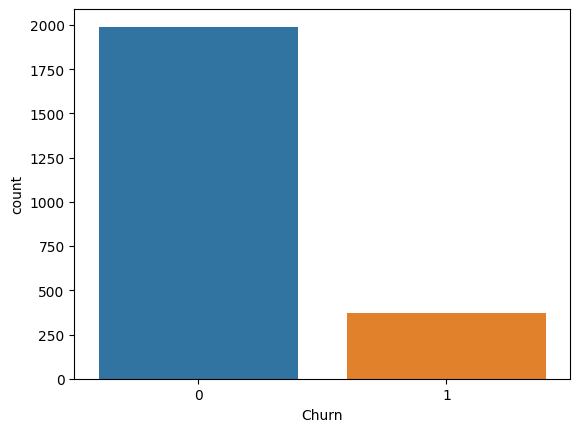

In [42]:
import seaborn as sns
sns.countplot(x=y_train)  # Gráfico de barras de clases

#### Separamos Set de datos de prueba y entrenamiento

In [13]:
# test_size = 0.25 indica que el 25% de los datos se tomarán como prueba y se entrenará con el 75%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#### Creamos el modelo, lo entrenamo y lo usamos sobre las pruebas

In [54]:
# instantiate the model (using the default parameters)
# logreg = LogisticRegression() # Genera error de convergencia TOTAL NO. of ITERATIONS REACHED LIMIT.
logreg = LogisticRegression(solver='lbfgs', max_iter=10000) # Aumentamos las iteraciones para buscar la convergencia con el algoritmo 
                                                            # lbfgs = Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

#### Validamos el resultado del modelo con la matriz de confusión

In [55]:
from sklearn import metrics

matriz_confusion = metrics.confusion_matrix(y_test, y_pred)
matriz_confusion

array([[632,  33],
       [ 54,  69]], dtype=int64)

In [48]:
pd.DataFrame(matriz_confusion)

,0,1
0,632,33
1,54,69


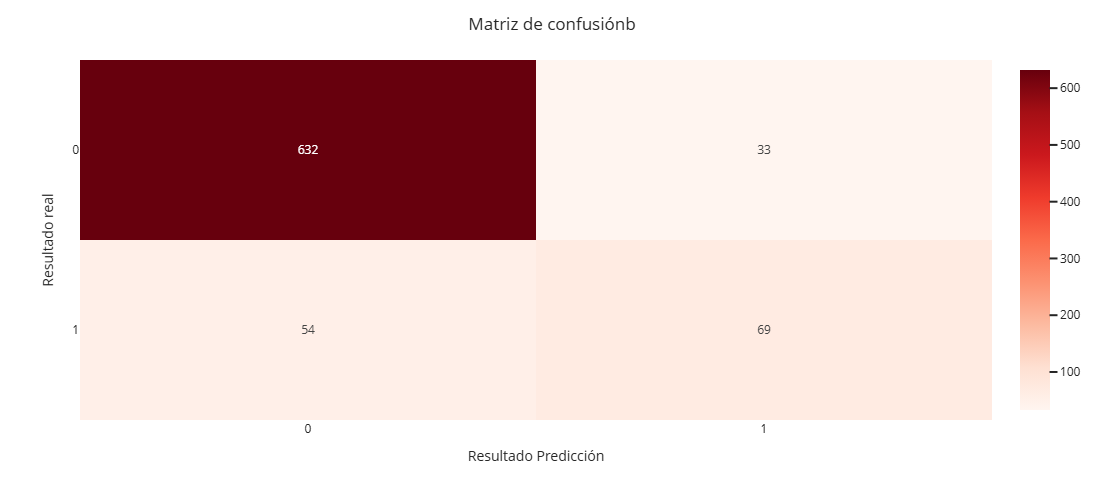

In [49]:
import plotly.express as px
from sklearn.metrics import confusion_matrix

def display_confusion_matrix(y_true, y_pred, labels=[0, 1]):
    cm = confusion_matrix(y_true, y_pred)
    
    dims = [str(l) for l in labels]

    fig = px.imshow(cm, 
                    x=dims, 
                    y=dims, 
                    color_continuous_scale='Reds', 
                    aspect="auto")

    fig.update_traces(text=cm, texttemplate="%{text}")

    fig.update_layout(title="Matriz de confusiónb",
                      xaxis_title='Resultado Predicción',
                      yaxis_title='Resultado real',
                      width=500, 
                      height=500, 
                      hovermode='closest',
                      template='seaborn')
    fig.show()
display_confusion_matrix(y_test, y_pred)

In [52]:
from sklearn.metrics import classification_report
target_names = ['No Churn', 'Churn']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    No Churn       0.92      0.95      0.94       665
       Churn       0.68      0.56      0.61       123

    accuracy                           0.89       788
   macro avg       0.80      0.76      0.77       788
weighted avg       0.88      0.89      0.89       788



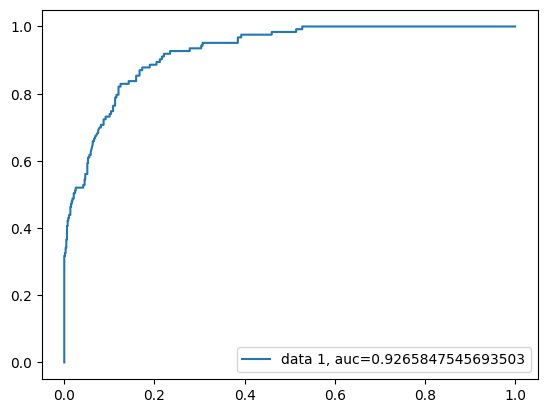

In [53]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Para las fórmulas, utilizaremos las siguientes abreviaturas:
*   **TP (True Positives):** Verdaderos Positivos (instancias correctamente clasificadas como positivas).
*   **FP (False Positives):** Falsos Positivos (instancias incorrectamente clasificadas como positivas, cuando en realidad son negativas).
*   **FN (False Negatives):** Falsos Negativos (instancias incorrectamente clasificadas como negativas, cuando en realidad son positivas).
*   **TN (True Negatives):** Verdaderos Negativos (instancias correctamente clasificadas como negativas).
*   **N_clase_i:** Número de instancias de la clase 'i'.

Aquí tienes la tabla:

| Métrica       | Definición Breve                                                                                                   | Fórmula de Cálculo                                                                                                                                                                                                       | Valor (No Churn) | Valor (Churn) | Valor (General/Total/AUC) | Guía de Interpretación (Umbrales Generales)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | Interpretación Clave                                                                                                                                                                                                                                                                                                                                           |
| :------------ | :----------------------------------------------------------------------------------------------------------------- | :----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | :--------------- | :------------ | :------------------------ | :---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | :----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Precision** | De los predichos como X, cuántos fueron realmente X.                                                               | TP / (TP + FP)                                                                                                                                                                                                           | 0.92             | 0.68          |                           | **> 0.85:** Muy bueno<br>**0.70 - 0.85:** Bueno<br>**0.50 - 0.70:** Aceptable/Necesita mejora<br>**< 0.50:** Pobre                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | **No Churn:** Muy bueno, el 92% de las predicciones de "No Churn" fueron correctas. <br> **Churn:** Aceptable, el 68% de las predicciones de "Churn" fueron correctas (32% de falsos positivos).                                                                                                                                                               |
| **Recall**    | De todos los que realmente son X, cuántos fueron identificados como X.                                             | TP / (TP + FN)                                                                                                                                                                                                           | 0.95             | 0.56          |                           | **> 0.85:** Muy bueno<br>**0.70 - 0.85:** Bueno<br>**0.50 - 0.70:** Aceptable/Necesita mejora<br>**< 0.50:** Pobre                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | **No Churn:** Excelente, el 95% de los clientes que no abandonaron fueron identificados. <br> **Churn:** **Bajo**, el modelo solo identifica al 56% de los clientes que realmente abandonan (un 44% de falsos negativos importantes para mejorar).                                                                                                      |
| **F1-Score**  | Media armónica de Precisión y Recall (equilibrio entre ambos).                                                     | 2 * (Precision * Recall) / (Precision + Recall)                                                                                                                                                                          | 0.94             | 0.61          |                           | **> 0.85:** Muy bueno<br>**0.70 - 0.85:** Bueno<br>**0.50 - 0.70:** Aceptable/Necesita mejora<br>**< 0.50:** Pobre                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | **No Churn:** Muy bueno, indica un equilibrio fuerte entre precisión y recall. <br> **Churn:** Moderado, afectado por el bajo recall para esta clase.                                                                                                                                                                                                 |
| **Support**   | Número de casos reales en el conjunto de prueba para cada clase.                                                   | Conteo de instancias reales por clase. (Ej: N_clase_No_Churn)                                                                                                                                                            | 665              | 123           | 788                       | No es una métrica de "bueno/malo"; indica la distribución de clases. **Importante:** grandes diferencias pueden indicar desequilibrio de clases.                                                                                                                                                                                                                                                                                                                                                                                                                                         | Muestra un **desequilibrio de clases**: muchos más clientes "No Churn" que "Churn" en el conjunto de datos de prueba.                                                                                                                                                                                                                                    |
| **Accuracy**  | Proporción de predicciones correctas totales.                                                                      | (TP + TN) / (TP + TN + FP + FN)                                                                                                                                                                                          |                  |               | 0.89                      | **> 0.90:** Excelente<br>**0.80 - 0.90:** Muy bueno<br>**0.70 - 0.80:** Bueno<br>**< 0.70:** Mejorable<br>**¡Cuidado con desequilibrio de clases!**                                                                                                                                                                                                                                                                                                                                                                                                                              | **Alta (89%)**, pero puede ser engañosa debido al desequilibrio de clases; principalmente impulsada por el buen rendimiento en la clase mayoritaria ("No Churn").                                                                                                                                                                                     |
| **Macro Avg** | Promedio simple de las métricas por clase (da igual peso a cada clase).                                            | (Métrica_Clase_1 + Métrica_Clase_2 + ... + Métrica_Clase_N) / N_clases                                                                                                                                                   |                  |               | Prec: 0.80, Rec: 0.76, F1: 0.77 | **> 0.85:** Muy bueno<br>**0.70 - 0.85:** Bueno<br>**0.50 - 0.70:** Aceptable/Necesita mejora<br>**< 0.50:** Pobre. **Ideal para evaluar rendimiento equitativo.**                                                                                                                                                                                                                                                                                                                                                                                          | Refleja mejor el rendimiento promedio entre ambas clases, destacando la diferencia con el "Weighted Avg" y el impacto del menor rendimiento en la clase "Churn".                                                                                                                                                                                           |
| **Weighted Avg** | Promedio de las métricas ponderado por el número de casos de cada clase.                                           | Σ (Métrica_Clase_i * N_clase_i) / Σ N_clase_i                                                                                                                                                                            |                  |               | Prec: 0.88, Rec: 0.89, F1: 0.89 | **> 0.85:** Muy bueno<br>**0.70 - 0.85:** Bueno<br>**0.50 - 0.70:** Aceptable/Necesita mejora<br>**< 0.50:** Pobre. **Cuidado con el sesgo por clases dominantes.**                                                                                                                                                                                                                                                                                                                                                                                               | Similar al Accuracy, ya que el peso de la clase "No Churn" es mucho mayor.                                                                                                                                                                                                                                                                                     |
| **AUC**       | Área bajo la curva ROC (mide la capacidad del modelo para distinguir entre clases, independiente del umbral).       | No tiene una fórmula simple aritmética. Es el área bajo la curva ROC, que grafica TPR (Recall) vs FPR (FP / (FP + TN)) en diferentes umbrales. Representa la probabilidad de que el clasificador ordene aleatoriamente un positivo más alto que un negativo. |                  |               | 0.9265                    | **> 0.90:** Excelente<br>**0.80 - 0.90:** Muy bueno<br>**0.70 - 0.80:** Bueno<br>**0.60 - 0.70:** Aceptable<br>**0.50:** No mejor que el azar                                                                                                                                                                                                                                                                                                                                                                                                                           | **Excelente.** El modelo tiene una capacidad muy alta para discriminar entre clientes que abandonan y los que no. Es una métrica robusta frente al desequilibrio de clases y sugiere que el modelo es muy bueno en la clasificación general de las probabilidades, a pesar de las métricas de clasificación directa en la clase "Churn". |

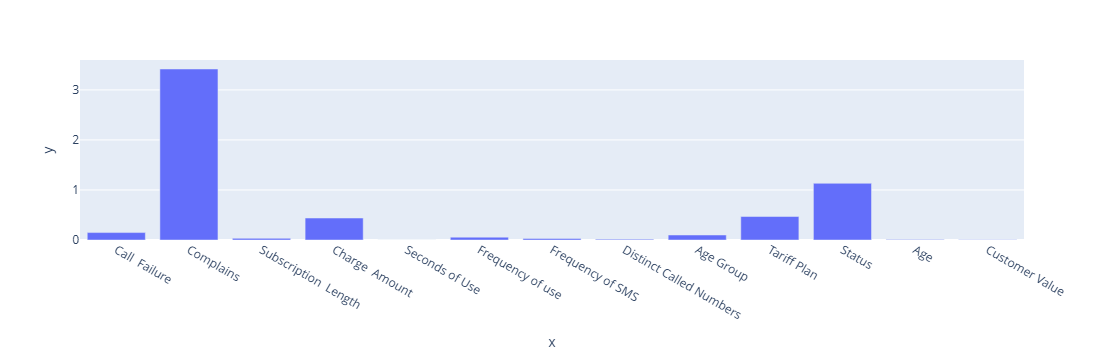

In [101]:
px.bar(y=np.abs(logreg.coef_[0]),x=logreg.feature_names_in_)
# px.bar(y=np.exp(np.abs(logreg.coef_[0])),x=logreg.feature_names_in_)
# logreg.coef_

In [69]:
filename = "modeloChurn.pkl"

# Guardar modelo
with open(filename, 'wb') as file:
    pickle.dump(logreg, file)

# Cargar modelo
with open(filename, 'rb') as file:
    modelo_cargado = pickle.load(file)

# Usa modelo_cargado para predicciones
predictions = modelo_cargado.predict(X_test.head(1))
predictions_prob = modelo_cargado.predict_proba(X_test.head(1))[::,1]

In [70]:
print("Predicción:",predictions[0])
print("Probabilidad:",predictions_prob[0])

Predicción: 0
Probabilidad: 0.4680508182178786


In [66]:
predictions_prob

array([0.46805082])

In [77]:
datos ={"Call  Failure":[50],"Complains":[0],"Subscription  Length":[10],"Charge  Amount":[3],"Seconds of Use":[3500],"Frequency of use":[130],"Frequency of SMS":[50],"Distinct Called Numbers":[130],"Age Group":[3],"Tariff Plan":[2],"Status":[1],"Age":[35],"Customer Value":[500]}
dfDatos = pd.DataFrame(datos)
# columnas = ['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
#        'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
#        'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
#        'Customer Value']
dfDatos.columns=columnas
loaded_model.predict(dfDatos)

array([0], dtype=int64)

In [72]:
X_test.head(1)

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value
318,0,0,31,0,0,0,0,0,2,1,2,25,0.0
